In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyber-bullying-data-for-multi-label-classification/Data_Distribution.png
/kaggle/input/cyber-bullying-data-for-multi-label-classification/final_hateXplain.csv
/kaggle/input/cyber-bullying-data-for-multi-label-classification/hateXplain.csv


# imports

In [2]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [3]:
dataset = pd.read_csv('/kaggle/input/cyber-bullying-data-for-multi-label-classification/final_hateXplain.csv')

In [4]:
dataset.head()

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN


# Data cleanind and preprocessing

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20109 entries, 0 to 20108
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             20109 non-null  object
 1   label               20109 non-null  object
 2   Race                20109 non-null  object
 3   Religion            20109 non-null  object
 4   Gender              20109 non-null  object
 5   Sexual Orientation  20109 non-null  object
 6   Miscellaneous       3533 non-null   object
dtypes: object(7)
memory usage: 1.1+ MB


# Due to a lot missing data in column : 'Miscellaneous', I will drop that column

In [6]:
dataset = dataset.drop(['Miscellaneous'],axis=1)

In [7]:
dataset.keys()

Index(['comment', 'label', 'Race', 'Religion', 'Gender', 'Sexual Orientation'], dtype='object')

# Now we will begin the NLP preprocessing on comment column

# Tokenization

In [8]:
dataset['comment'] = dataset['comment'].apply(lambda x: nltk.word_tokenize(x))

In [9]:
dataset

,comment,label,Race,Religion,Gender,Sexual Orientation
0,"[0, u0, lmao, wow, fuck, you, too, 😂, 😂]",normal,No_race,Nonreligious,No_gender,No_orientation
1,"[1, 0, th, floor, maybe, wow, cnn, with, the, ...",offensive,No_race,Nonreligious,No_gender,No_orientation
2,"[1, 0, yrs, <, number, >, white, women, raped,...",hatespeech,African,Nonreligious,No_gender,No_orientation
3,"[1, 2, h, ago, ching, chong, accepted, your, f...",offensive,Asian,Nonreligious,No_gender,No_orientation
4,"[1, 8, th, century, mayhem, and, lawlessness, ...",normal,No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...,...
20104,"[😂, 😂, 😂, 😂, 😂, y, ’, all, be, so, mad, at, ca...",offensive,African,Nonreligious,No_gender,No_orientation
20105,"[🤔, 🤔, 🤔, 🤔, mmm, yes, the, trebuchet, memes, ...",hatespeech,Arab,Islam,No_gender,No_orientation
20106,"[🤣, this, so, ghetto, i, ’, m, ready, to, get,...",offensive,No_race,Nonreligious,No_gender,No_orientation
20107,"[🤣, 🤣, 😂, 😂, 🤣, 🤣, 😂, 😂, 🤣, 🤣, you, spelled, m...",hatespeech,Arab,Nonreligious,No_gender,No_orientation


# removing stopwords

In [10]:
def removing_stopwords_in_tokens_list(tokens_list):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens_list if word not in stop_words]
    
    return filtered_tokens

dataset['comment'] = dataset['comment'].apply(lambda tokens_list: removing_stopwords_in_tokens_list(tokens_list))

In [11]:
dataset

,comment,label,Race,Religion,Gender,Sexual Orientation
0,"[0, u0, lmao, wow, fuck, 😂, 😂]",normal,No_race,Nonreligious,No_gender,No_orientation
1,"[1, 0, th, floor, maybe, wow, cnn, fakenews, b...",offensive,No_race,Nonreligious,No_gender,No_orientation
2,"[1, 0, yrs, <, number, >, white, women, raped,...",hatespeech,African,Nonreligious,No_gender,No_orientation
3,"[1, 2, h, ago, ching, chong, accepted, friend,...",offensive,Asian,Nonreligious,No_gender,No_orientation
4,"[1, 8, th, century, mayhem, lawlessness, nothi...",normal,No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...,...
20104,"[😂, 😂, 😂, 😂, 😂, ’, mad, caucasians, failing, f...",offensive,African,Nonreligious,No_gender,No_orientation
20105,"[🤔, 🤔, 🤔, 🤔, mmm, yes, trebuchet, memes, much,...",hatespeech,Arab,Islam,No_gender,No_orientation
20106,"[🤣, ghetto, ’, ready, get, tf]",offensive,No_race,Nonreligious,No_gender,No_orientation
20107,"[🤣, 🤣, 😂, 😂, 🤣, 🤣, 😂, 😂, 🤣, 🤣, spelled, name, ...",hatespeech,Arab,Nonreligious,No_gender,No_orientation


# as we can see there are lot digits with string data, we will remove them. Not sucessfull with this step

In [12]:
def removing_digits_in_tokens_list(tokens_list):
    token_filtered = []
    for token in tokens_list:
        result = ''.join([i for i in token if not i.isdigit()])
        if result:  # Ne garde que les tokens non vides
            token_filtered.append(result)
    
    return token_filtered

In [13]:
list = ['0, u0, lmao, wow, fuck, 😂, 😂']
removing_digits_in_tokens_list(list)

[', u, lmao, wow, fuck, 😂, 😂']

In [14]:
dataset['comment'] = dataset['comment'].apply(lambda tokens:removing_digits_in_tokens_list(tokens))

In [15]:
dataset

,comment,label,Race,Religion,Gender,Sexual Orientation
0,"[u, lmao, wow, fuck, 😂, 😂]",normal,No_race,Nonreligious,No_gender,No_orientation
1,"[th, floor, maybe, wow, cnn, fakenews, body, c...",offensive,No_race,Nonreligious,No_gender,No_orientation
2,"[yrs, <, number, >, white, women, raped, nigge...",hatespeech,African,Nonreligious,No_gender,No_orientation
3,"[h, ago, ching, chong, accepted, friend, reque...",offensive,Asian,Nonreligious,No_gender,No_orientation
4,"[th, century, mayhem, lawlessness, nothing, lo...",normal,No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...,...
20104,"[😂, 😂, 😂, 😂, 😂, ’, mad, caucasians, failing, f...",offensive,African,Nonreligious,No_gender,No_orientation
20105,"[🤔, 🤔, 🤔, 🤔, mmm, yes, trebuchet, memes, much,...",hatespeech,Arab,Islam,No_gender,No_orientation
20106,"[🤣, ghetto, ’, ready, get, tf]",offensive,No_race,Nonreligious,No_gender,No_orientation
20107,"[🤣, 🤣, 😂, 😂, 🤣, 🤣, 😂, 😂, 🤣, 🤣, spelled, name, ...",hatespeech,Arab,Nonreligious,No_gender,No_orientation


# lemmatize the text

In [16]:
# Télécharger les ressources nécessaires
nltk.download('wordnet')  # Télécharger WordNet pour la lemmatisation
nltk.download('omw-1.4')  # Télécharger les données supplémentaires pour WordNet

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [17]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [18]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens_list):
    filtered_tokens = []
    for token in tokens_list:
        lemmatized_token = lemmatizer.lemmatize(token)
        filtered_tokens.append(lemmatized_token)
        
    return filtered_tokens

In [19]:
list = ['rock','corpora','better']
lemmatize_tokens(list)

['rock', 'corpus', 'better']

In [20]:
dataset['comment'] = dataset['comment'].apply(lambda x:lemmatize_tokens(x))

In [21]:
dataset

,comment,label,Race,Religion,Gender,Sexual Orientation
0,"[u, lmao, wow, fuck, 😂, 😂]",normal,No_race,Nonreligious,No_gender,No_orientation
1,"[th, floor, maybe, wow, cnn, fakenews, body, c...",offensive,No_race,Nonreligious,No_gender,No_orientation
2,"[yr, <, number, >, white, woman, raped, nigger...",hatespeech,African,Nonreligious,No_gender,No_orientation
3,"[h, ago, ching, chong, accepted, friend, reque...",offensive,Asian,Nonreligious,No_gender,No_orientation
4,"[th, century, mayhem, lawlessness, nothing, lo...",normal,No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...,...
20104,"[😂, 😂, 😂, 😂, 😂, ’, mad, caucasian, failing, fo...",offensive,African,Nonreligious,No_gender,No_orientation
20105,"[🤔, 🤔, 🤔, 🤔, mmm, yes, trebuchet, meme, much, ...",hatespeech,Arab,Islam,No_gender,No_orientation
20106,"[🤣, ghetto, ’, ready, get, tf]",offensive,No_race,Nonreligious,No_gender,No_orientation
20107,"[🤣, 🤣, 😂, 😂, 🤣, 🤣, 😂, 😂, 🤣, 🤣, spelled, name, ...",hatespeech,Arab,Nonreligious,No_gender,No_orientation


# removing emojis in comments

In [22]:
def removing_special_characters(tokens_list):
    result = [''.join(letter for letter in token if letter.isalnum()) for token in tokens_list]
    
    return result

In [23]:
list = ["Ge;ek * s:fo ! r;Ge * e*k:s !","<number>$$"]
removing_special_characters(list)

['GeeksforGeeks', 'number']

In [24]:
dataset['comment'] = dataset['comment'].apply(lambda x:removing_special_characters(x))

In [25]:
dataset

,comment,label,Race,Religion,Gender,Sexual Orientation
0,"[u, lmao, wow, fuck, , ]",normal,No_race,Nonreligious,No_gender,No_orientation
1,"[th, floor, maybe, wow, cnn, fakenews, body, c...",offensive,No_race,Nonreligious,No_gender,No_orientation
2,"[yr, , number, , white, woman, raped, nigger, ...",hatespeech,African,Nonreligious,No_gender,No_orientation
3,"[h, ago, ching, chong, accepted, friend, reque...",offensive,Asian,Nonreligious,No_gender,No_orientation
4,"[th, century, mayhem, lawlessness, nothing, lo...",normal,No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...,...
20104,"[, , , , , , mad, caucasian, failing, forget, ...",offensive,African,Nonreligious,No_gender,No_orientation
20105,"[, , , , mmm, yes, trebuchet, meme, much, nice...",hatespeech,Arab,Islam,No_gender,No_orientation
20106,"[, ghetto, , ready, get, tf]",offensive,No_race,Nonreligious,No_gender,No_orientation
20107,"[, , , , , , , , , , spelled, name, wrong, nam...",hatespeech,Arab,Nonreligious,No_gender,No_orientation


# remove empty string

In [26]:
def remove_empty_string(tokens_list):
    result = [token for token in tokens_list if token]
    
    return result

In [27]:
list= ["","" ,"" ,"" ,"" ,"" , "mad", "caucasian", "failing", "forget"]
remove_empty_string(list)

['mad', 'caucasian', 'failing', 'forget']

In [28]:
dataset['comment'] = dataset['comment'].apply(lambda x: remove_empty_string(x))

In [29]:
dataset

,comment,label,Race,Religion,Gender,Sexual Orientation
0,"[u, lmao, wow, fuck]",normal,No_race,Nonreligious,No_gender,No_orientation
1,"[th, floor, maybe, wow, cnn, fakenews, body, c...",offensive,No_race,Nonreligious,No_gender,No_orientation
2,"[yr, number, white, woman, raped, nigger, numb...",hatespeech,African,Nonreligious,No_gender,No_orientation
3,"[h, ago, ching, chong, accepted, friend, request]",offensive,Asian,Nonreligious,No_gender,No_orientation
4,"[th, century, mayhem, lawlessness, nothing, lo...",normal,No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...,...
20104,"[mad, caucasian, failing, forget, black, selli...",offensive,African,Nonreligious,No_gender,No_orientation
20105,"[mmm, yes, trebuchet, meme, much, nicer, catap...",hatespeech,Arab,Islam,No_gender,No_orientation
20106,"[ghetto, ready, get, tf]",offensive,No_race,Nonreligious,No_gender,No_orientation
20107,"[spelled, name, wrong, name, literally, front,...",hatespeech,Arab,Nonreligious,No_gender,No_orientation


# classification part

In [30]:
target = dataset['label']
features = dataset.drop('label',axis=1)

In [31]:
features

,comment,Race,Religion,Gender,Sexual Orientation
0,"[u, lmao, wow, fuck]",No_race,Nonreligious,No_gender,No_orientation
1,"[th, floor, maybe, wow, cnn, fakenews, body, c...",No_race,Nonreligious,No_gender,No_orientation
2,"[yr, number, white, woman, raped, nigger, numb...",African,Nonreligious,No_gender,No_orientation
3,"[h, ago, ching, chong, accepted, friend, request]",Asian,Nonreligious,No_gender,No_orientation
4,"[th, century, mayhem, lawlessness, nothing, lo...",No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...
20104,"[mad, caucasian, failing, forget, black, selli...",African,Nonreligious,No_gender,No_orientation
20105,"[mmm, yes, trebuchet, meme, much, nicer, catap...",Arab,Islam,No_gender,No_orientation
20106,"[ghetto, ready, get, tf]",No_race,Nonreligious,No_gender,No_orientation
20107,"[spelled, name, wrong, name, literally, front,...",Arab,Nonreligious,No_gender,No_orientation


In [32]:
features['comment'] = features['comment'].apply(lambda x: ' '.join(x))

In [33]:
features

,comment,Race,Religion,Gender,Sexual Orientation
0,u lmao wow fuck,No_race,Nonreligious,No_gender,No_orientation
1,th floor maybe wow cnn fakenews body count goi...,No_race,Nonreligious,No_gender,No_orientation
2,yr number white woman raped nigger number negr...,African,Nonreligious,No_gender,No_orientation
3,h ago ching chong accepted friend request,Asian,Nonreligious,No_gender,No_orientation
4,th century mayhem lawlessness nothing loud mou...,No_race,Nonreligious,No_gender,No_orientation
...,...,...,...,...,...
20104,mad caucasian failing forget black selling u,African,Nonreligious,No_gender,No_orientation
20105,mmm yes trebuchet meme much nicer catapult mem...,Arab,Islam,No_gender,No_orientation
20106,ghetto ready get tf,No_race,Nonreligious,No_gender,No_orientation
20107,spelled name wrong name literally front face n...,Arab,Nonreligious,No_gender,No_orientation


In [34]:
preprocessing = ColumnTransformer(
     transformers=[
        ('tfidf', TfidfVectorizer(), 'comment'),  # TF-IDF pour les commentaires
        ('onehot', OneHotEncoder(), ['Race', 'Religion', 'Gender', 'Sexual Orientation'])  # One-Hot Encoding pour les variables catégoriques
    ]
)

In [35]:
pipeline = Pipeline(steps=[
    ('preprocessing',preprocessing),
    ('classifier',RandomForestClassifier(random_state=42))
])

In [36]:
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

In [37]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'comment'),
                                                 ('onehot', OneHotEncoder(),
                                                  ['Race', 'Religion', 'Gender',
                                                   'Sexual Orientation'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [38]:
predictions = pipeline.predict(X_test)

In [39]:
from sklearn.metrics import *
def compute_metrics(y_true,predictions):
    """
    accuracy = accuracy_score(y_true,predictions)
    recall = recall_score(y_true,predictions)
    f1score = f1_score(y_true,predictions)
    precision = precision_score(y_true,predictions)
    """
    cr = classification_report(y_true,predictions)
    print(cr)
    
    cm = confusion_matrix(y_true,predictions)
    confusion_matrix_display =  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    confusion_matrix_display.plot()
    """
    metrics = {
        'accuracy':accuracy,
        'recall':recall,
        'f1_score':f1score,
        'precision':precision
    }
    """
    #return metrics

              precision    recall  f1-score   support

  hatespeech       0.72      0.80      0.76      1325
      normal       0.77      0.83      0.80      1502
   offensive       0.61      0.48      0.54      1195

    accuracy                           0.72      4022
   macro avg       0.70      0.71      0.70      4022
weighted avg       0.71      0.72      0.71      4022



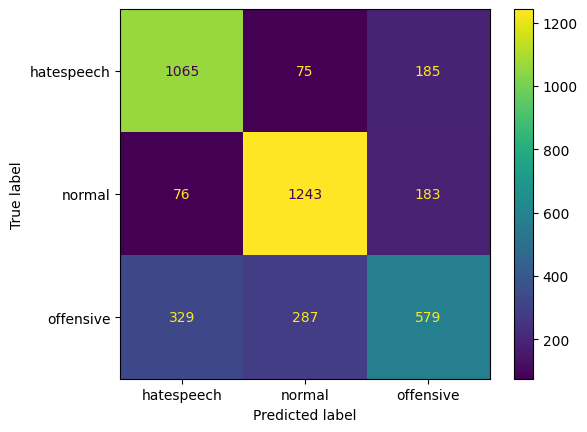

In [40]:
compute_metrics(y_test,predictions)

In [41]:
score = cross_val_score(pipeline, features, target, cv=3)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/pipeline.py", line 718, in score
    Xt = transform.transform(Xt)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 800, in transform
    Xs = self._fit_transform(
  File "/opt/conda/lib/python3.10/site-packages/skl

In [42]:
print(score)

[0.70535581 0.71564971        nan]


# 